In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler


from sklearn import datasets, linear_model
from scipy.stats import linregress

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info

import pprint
import warnings
import os

warnings.filterwarnings("ignore")

In [2]:
# import our own functions
import rep_drift, visualize_drift

In [3]:
# glabal variables:
n_sessions = 3
n_repeats = 10
n_divs = 30

---
### One example session:
Where in half of the repeats the mouse was active.

In [4]:
def plot_run(run_vals):

    fig, ax = plt.subplots(figsize=(14,4))
    colors = plt.cm.summer(np.linspace(0, 1, 10))

    ax.set_ylim([0, 80])
    ax.set_ylabel('cm/s', fontsize = 16)

    ax.text(0, 72, 'Repeats:', fontsize = 14)
    # ax.hlines(0, 0, 29, linestyles= '--', color = 'black')
    for i in range(10):
        ax.plot(run_vals[i,:], color = colors[i])
        ax.text(i+3, 72, i, color = colors[i], fontsize = 14)
    
    plt.show()

In [7]:
boc = BrainObservatoryCache()
data_set = boc.get_ophys_experiment_data(571494829)
cell_ids, dff_vals, run_vals = rep_drift.get_response_vals(data_set)

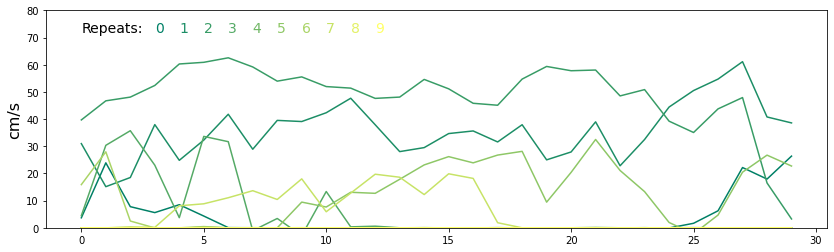

In [8]:
plot_run(run_vals)

In [9]:
# get crrelation matrix and angle matrix:
corrs_s, angles_s = rep_drift.calc_similarity(dff_vals)
run_spd_per_repeat = np.nanmean(run_vals, axis = 1)

# sort the repeats by mean running speed:
run_repeat_sort_idx = np.argsort(run_spd_per_repeat)
print(run_repeat_sort_idx) # from the slowest to the fastest

[9 4 8 6 0 3 7 5 1 2]


In [10]:
# the dicotomy is not that clean; but we can try to bin the in the middle:
print('If we use 5 cm/s as the cut-off then', np.sum(run_spd_per_repeat < 5), 'of 10 repeats the mouse were considered to be running.')

If we use 5 cm/s as the cut-off then 5 of 10 repeats the mouse were considered to be running.


In [12]:
# organize the pearson corr according to the repeat's mean running speed:
# so that the 1st repeat block is the one with the smallest running spd, and the last one is the one with largest running spd.
n_repeats = 10
n_divs = 30

# reorganize repeats by mean running speed during a movie:
corrs_ordered = np.zeros((n_repeats*n_divs, n_repeats*n_divs))

for repeat_idx1 in range(n_repeats):
    for repeat_idx2 in range(n_repeats):
        corrs_ordered[  
            run_repeat_sort_idx[repeat_idx1]*n_divs : (run_repeat_sort_idx[repeat_idx1]+1)*n_divs,
            run_repeat_sort_idx[repeat_idx2]*n_divs : (run_repeat_sort_idx[repeat_idx2]+1)*n_divs,
            ] = corrs_s[
                repeat_idx1*n_divs : (repeat_idx1+1)*n_divs, 
                repeat_idx2*n_divs : (repeat_idx2+1)*n_divs
            ]

In [13]:
corrs_ordered_triu = np.triu(corrs_ordered, k = 1)

We compare the R values within the running group to wihtin the not running group.

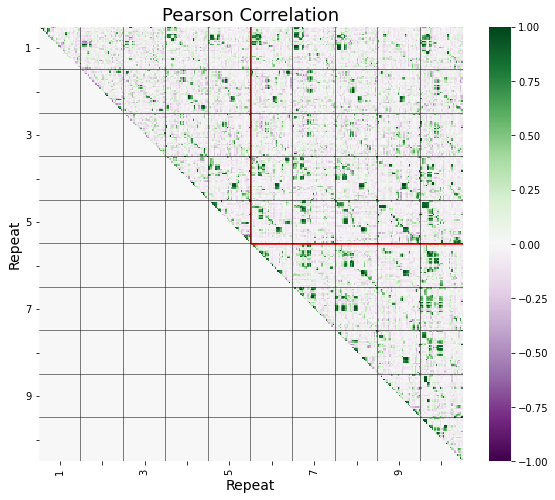

In [15]:
n_repeat_plot = 10
_, ax = plt.subplots(1, 1, figsize=(9.5,8))

sns.heatmap(corrs_ordered_triu[:n_repeat_plot*n_divs, :n_repeat_plot*n_divs], 
            cmap = 'PRGn', vmin = -1, vmax = 1,
            ax = ax)

tick_locs = [n_divs/2 + i * n_divs for i in range(n_repeat_plot)]
ax.set_xticks(tick_locs)
ax.set_yticks(tick_locs)

tick_labels = [1, None, 3, None, 5, None, 7, None, 9, None]

ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)
ax.set_xlabel('Repeat', fontsize = 14)
ax.set_ylabel('Repeat', fontsize = 14)
ax.set_title('Pearson Correlation', fontsize = 18)

for repeat_idx in range(1, n_repeat_plot):
    ax.axhline((repeat_idx * n_divs)-0.5, color='k', linewidth=0.5)
    ax.axvline((repeat_idx * n_divs)-0.5, color='k', linewidth=0.5)

ax.hlines(5*n_divs, 5*n_divs, 300, color = 'r')
ax.vlines(5*n_divs, 0, 5*n_divs, color = 'r')


plt.show()

They are `within_no_run` and `within_run` respectively. 

In [16]:
within_no_run_bin = corrs_ordered_triu[0*n_divs:5*n_divs, 0*n_divs:5*n_divs]
within_run_bin = corrs_ordered_triu[5*n_divs:, 5*n_divs:]

In [17]:
within_no_run_bin_flat = within_no_run_bin.flatten()
within_no_run_bin_ff = within_no_run_bin_flat[np.where(within_no_run_bin_flat != 0)] # get rid of lower tri. that we set to zero

within_run_bin_flat = within_run_bin.flatten()
within_run_bin_ff = within_run_bin_flat[np.where(within_run_bin_flat != 0)]

We can see that the distribution is enriched for running group where R > 0.25:

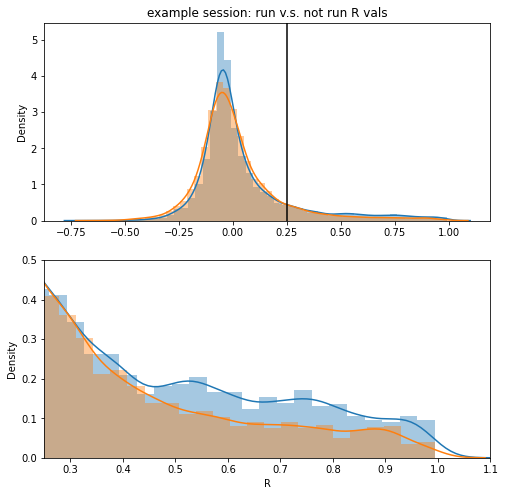

In [19]:
# sns.histplot(across_bins_flat)

fig, ax = plt.subplots(2, 1, figsize = [8,8])

sns.distplot(within_run_bin_ff, kde = True, ax = ax[0])
sns.distplot(within_no_run_bin_ff, kde = True,  ax = ax[0])
# sns.distplot(across_bins, kde = True,  ax = ax[0])
ax[0].axvline(.25, color = 'k')
ax[0].set_title('example session: run v.s. not run R vals')


ax[1].set_xlim([.25, 1.1])
ax[1].set_ylim([0,.5])
sns.distplot(within_run_bin_ff, kde = True, ax = ax[1])
sns.distplot(within_no_run_bin_ff, kde = True,  ax = ax[1])
# sns.distplot(across_bins, kde = True,  ax = ax[1])
ax[1].set_xlabel('R')

plt.show()

We also want to find out what contributes to this enrichment in similarity, and we are particularly interested whether the R-values are higher for neighboring seconds in the running group. 

In [20]:
delta_t_mat = np.zeros_like(within_run_bin)
delta_t_flat_half = []
for i in range(0, delta_t_mat.shape[0]):
    for j in range(i+1,delta_t_mat.shape[0]):
        delta_t_mat[i][j] = np.abs(i - j)%n_divs
        delta_t_flat_half.append(np.abs(i - j)%n_divs)

In [21]:
R_vals_df = pd.DataFrame(data = np.asarray([
    delta_t_flat_half, within_run_bin_ff.tolist(), within_no_run_bin_ff.tolist()]).T,
    columns = ['delta_t', 'run', 'no_run'])

Plot R-values by time-difference:

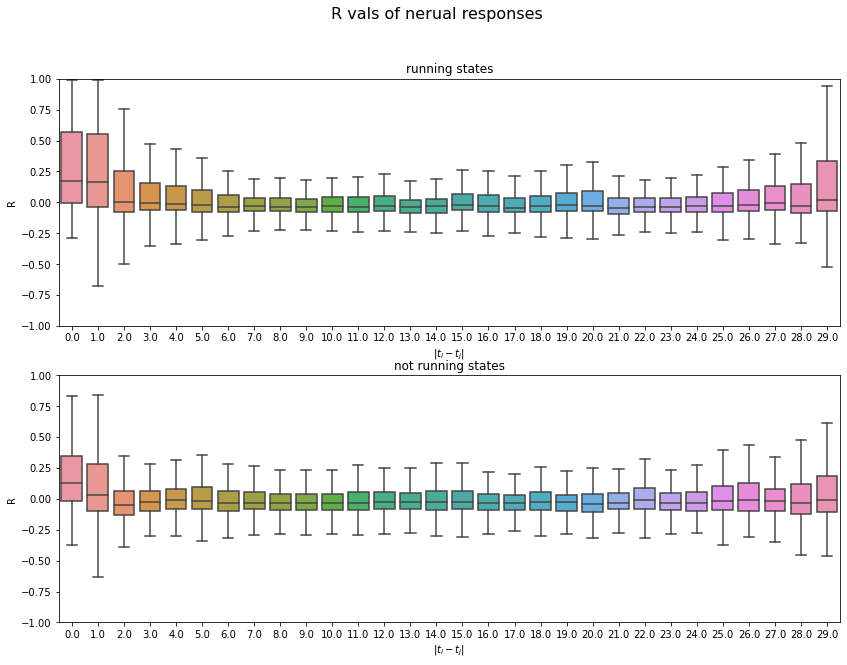

In [22]:
fig, ax = plt.subplots(ncols = 1, nrows = 2, figsize = (14, 10))
sns.boxplot(data = R_vals_df, x = 'delta_t', y = 'run',  showfliers = False, ax = ax[0])
ax[0].set_ylim([-1, 1])
ax[0].set_xlabel('$|t_i - t_j|$')
ax[0].set_ylabel('R')
ax[0].set_title('running states')
sns.boxplot(data = R_vals_df, x = 'delta_t', y = 'no_run', showfliers = False, ax = ax[1])
ax[1].set_ylim([-1, 1])
fig.suptitle('R vals of nerual responses', fontsize = 16)
ax[1].set_ylim([-1, 1])
ax[1].set_xlabel('$|t_i - t_j|$')
ax[1].set_ylabel('R')
ax[1].set_title('not running states')
plt.show()

Let's focus on similarity of the stimuli that are close in the temporal sequence (next second, next next second...), and we plot for representation similarities of the response vectors for 0-6 seconds apart.

Can see that running is above not-running and the differences diminish when the stimuli are too far apart in time.

In [23]:
R_vals_df_6 = R_vals_df.loc[R_vals_df['delta_t'] <= 6]
R_vals_df_6_melt = pd.melt(R_vals_df_6, id_vars=['delta_t'], value_vars=['run','no_run'],
        var_name='state', value_name='r_val')
R_vals_df_6_melt['delta_t'] = R_vals_df_6_melt['delta_t'].astype(int)
R_means = R_vals_df_6_melt.groupby(['delta_t', 'state']).mean()
R_means = R_means.reset_index()

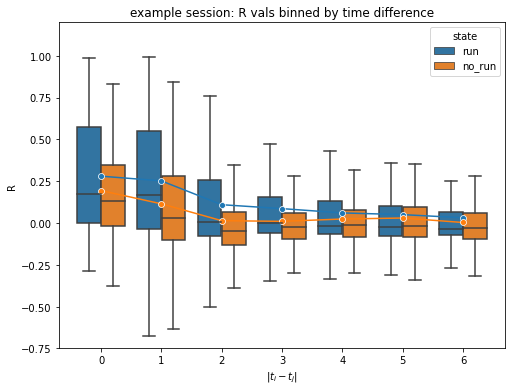

In [24]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.boxplot(data = R_vals_df_6_melt, 
            x = 'delta_t', y = 'r_val', hue = 'state', 
            showfliers = False, 
            ax = ax)
sns.lineplot(data=R_means, 
            x ='delta_t', y='r_val', hue='state', hue_order = ['run', 'no_run'],
            marker='o', ax=ax, legend = False)

ax.set_ylim([-.75, 1.2])
ax.set_xlabel('$|t_i - t_j|$')
ax.set_ylabel('R')
ax.set_title('example session: R vals binned by time difference')
plt.show()
# fig.savefig('time_diff.pdf')